# Network Analysis


## Part 1: Graph Construction and Visualization

Data source: http://networksciencebook.com/translations/en/resources/data.html

Note: requires networkx version < 2.7


In [2]:
# import packages
import numpy as np
import networkx as nx
import collections
import matplotlib.pyplot as plt

In [32]:
def initialize_graph(filename, directed):
    # import data
    edges = []
    with open(filename, 'r') as f:
        line = f.readline()
        while line:
            arr = line.strip('\n').split('\t')
            edges.append((arr[0], arr[1]))
            line = f.readline()

    # select largest connected component
    if directed:
        g = nx.DiGraph()
        g.add_edges_from(edges)
        if nx.is_weakly_connected(g):
            largest_con_g = g
        else:
            connected_components = list(nx.weakly_connected_components(g))
            largest_con_g = max(connected_components, key=len)

    else:
        ug = nx.Graph()
        ug.add_edges_from(edges)
        if nx.is_connected(ug):
            largest_con_g = ug
        else:
            connected_components = list(nx.connected_components(ug))
            largest_con_g = max(connected_components, key=len)

    return largest_con_g

### Dataset 1: Metabolic


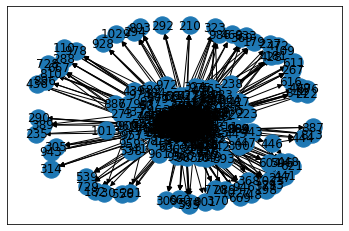

In [10]:
f1 = './datasets/metabolic.edgelist.txt'
g1 = initialize_graph(f1, True)
nx.draw_networkx(g1)

### Dataset 2: Powergrid


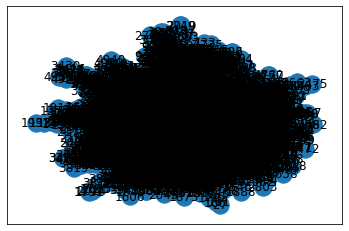

In [26]:
f2 = './datasets/powergrid.edgelist.txt'
g2 = initialize_graph(f2, False)
nx.draw_networkx(g2)

## Network Attributes


### Empirical Network


In [35]:
def get_attributes(g):
    # number of nodes, number of links, average clustering coefficient, average degree, average shortest path
    n = g.number_of_nodes()
    NE = g.number_of_edges()
    C = np.round(nx.average_clustering(g), 3)
    K = np.round(np.mean(list(dict(g.degree()).values())), 3)
    L = np.round(nx.average_shortest_path_length(g), 3)

    print("# NODES:", n)
    print("# LINKS:", NE)
    print("average clustering coefficient <C>: ", C)
    print("average degree <K>: ", K)
    print("average shortest path <L>: ", L)
    print("---------------------------")

    attributes = {'#NODES': n, '#LINKS': NE, '<C>': C, '<K>': K, '<L>': L}
    return attributes

In [36]:
attributes_g1 = get_attributes(g1)

# NODES: 1039
# LINKS: 5802
average clustering coefficient <C>:  0.281
average degree <K>:  11.168
average shortest path <L>:  2.572
---------------------------


In [37]:
attributes_g2 = get_attributes(g2)

# NODES: 4941
# LINKS: 6594
average clustering coefficient <C>:  0.08
average degree <K>:  2.669
average shortest path <L>:  18.989
---------------------------


### Small World Network Model


In [43]:
# Small World Network Model
def gen_sw_model(attributes, k, seed=None):
    n = attributes['#NODES']
    C = attributes['<C>']
    C0 = nx.average_clustering(nx.watts_strogatz_graph(n, k, 0))
    p = 1 - pow(C / C0, 1 / 3)

    g_sw = nx.watts_strogatz_graph(n, k, p, seed=seed)
    attributes_sw = get_attributes(g_sw)
    attributes_sw['<p>'] = p
    print('p in Small World Model: ', p)

    return g_sw, attributes_sw

In [44]:
g1_sw, attributes_g1_sw = gen_sw_model(attributes_g1, 12)

# NODES: 1039
# LINKS: 6234
average clustering coefficient <C>:  0.278
average degree <K>:  12.0
average shortest path <L>:  3.438
---------------------------
p in Small World Model:  0.25581785269322954


In [45]:
g2_sw, attributes_g2_sw = gen_sw_model(attributes_g2, 8)

# NODES: 4941
# LINKS: 19764
average clustering coefficient <C>:  0.084
average degree <K>:  8.0
average shortest path <L>:  4.558
---------------------------
p in Small World Model:  0.5007418408521138


### Barabasi-Albert Network Model


In [46]:
# Barabasi-Albert Network Model
def gen_ba_model(attributes, m, seed=None):
    n = attributes['#NODES']

    g_ba = nx.barabasi_albert_graph(n, m, seed=seed)
    attributes_ba = get_attributes(g_ba)
    return g_ba, attributes_ba

In [47]:
g1_ba, attributes_g1_ba = gen_ba_model(attributes_g1, 6)

# NODES: 1039
# LINKS: 6198
average clustering coefficient <C>:  0.043
average degree <K>:  11.931
average shortest path <L>:  2.853
---------------------------


In [48]:
g2_ba, attributes_g2_ba = gen_ba_model(attributes_g2, 4)

# NODES: 4941
# LINKS: 19748
average clustering coefficient <C>:  0.011
average degree <K>:  7.994
average shortest path <L>:  3.688
---------------------------


### Erdos-Renji Model


In [63]:
# Erdos-Renji Model
def gen_er_model(attributes, seed=None):
    n = attributes['#NODES']
    NE = attributes['#LINKS']
    p = 2 * NE / (n * (n - 1))

    # generate the Erdos-Renji model
    g_er = nx.erdos_renyi_graph(n, p, seed=seed)
    # select the largest connected component
    if nx.is_connected(g_er):
        largest_con_ger = g_er
    else:
        #connected_components = list(nx.connected_components(g_er))
        connected_components = [g_er.subgraph(p).copy() for p in nx.connected_components(g_er)]
        largest_con_ger = max(connected_components, key=len)

    attributes_er = get_attributes(largest_con_ger)
    attributes_er['<p>'] = 'p'
    print('p in Erdos-Renji Model: ', p)
    return largest_con_ger, attributes_er

In [50]:
g1_er, attributes_g1_er = gen_er_model(attributes_g1)

# NODES: 1039
# LINKS: 5681
average clustering coefficient <C>:  0.011
average degree <K>:  10.936
average shortest path <L>:  3.161
---------------------------
p in Erdos-Renji Model:  0.010759567614480353


In [64]:
g2_er, attributes_g2_er = gen_er_model(attributes_g2)

# NODES: 4545
# LINKS: 6628
average clustering coefficient <C>:  0.001
average degree <K>:  2.917
average shortest path <L>:  8.43
---------------------------
p in Erdos-Renji Model:  0.0005403026973346214


## The Degree of Histograms

We are going to plot the degree of histograms of both the empirical network and the
the three models.

Since the maximum degrees of empirical networks are very big, making the whole histogram hard to identify, the shown histograms will zoom into 0~30 degrees, which should be sufficient to show tendencies.


In [65]:
def plot_hist(g, g_sw, g_ba, g_er, dataset_name):

    # Empirical network
    e_deg_seq = sorted([d for n, d in g.degree()], reverse=True)
    e_deg_count = collections.Counter(e_deg_seq)
    e_deg, e_count = zip(*e_deg_count.items())

    # Small World model
    sw_deg_seq = sorted([d for n, d in g_sw.degree()], reverse=True)
    sw_deg_count = collections.Counter(sw_deg_seq)
    sw_deg, sw_count = zip(*sw_deg_count.items())

    # Barabasi-Albert Network Model
    ba_deg_seq = sorted([d for n, d in g_ba.degree()], reverse=True)
    ba_deg_count = collections.Counter(ba_deg_seq)
    ba_deg, ba_count = zip(*ba_deg_count.items())

    # Erdos-Renji Model
    er_deg_seq = sorted([d for n, d in g_er.degree()], reverse=True)
    er_deg_count = collections.Counter(er_deg_seq)
    er_deg, er_count = zip(*er_deg_count.items())

    w = 0.2

    # Plot each model
    plt.figure(figsize=(10, 10))
    e_deg = [(i - 1.5 * w) for i in e_deg]
    sw_deg = [(i - 0.5 * w) for i in sw_deg]
    ba_deg = [(i + 0.5 * w) for i in ba_deg]
    er_deg = [(i + 1.5 * w) for i in er_deg]
    plt.bar(e_deg, e_count, width=w, color="r", label='Empirical model')
    plt.bar(sw_deg, sw_count, width=w, color="g", label='Small World model')
    plt.bar(ba_deg,
            ba_count,
            width=w,
            color="b",
            label='Barabasi-Albert model')
    plt.bar(er_deg, er_count, width=w, color="y", label='Erdos-Renji model')
    plt.title(dataset_name +
              " Degree Histogram of the Empirical Network and Models")
    plt.ylabel("# of Nodes")
    plt.xlabel("Degree")
    plt.ylim(
        0,
        max(max(e_count), max(sw_count), max(ba_count), max(er_count)) + 1)
    plt.xlim(0, 30)
    print(max(max(e_deg), max(sw_deg), max(ba_deg), max(er_deg)))
    plt.legend(loc='best')
    plt.show()

905.7


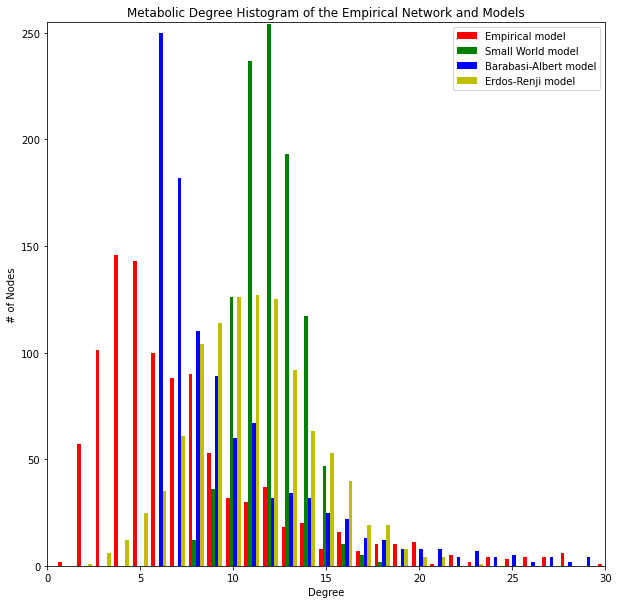

In [66]:
plot_hist(g1, g1_sw, g1_ba, g1_er, 'Metabolic')

215.1


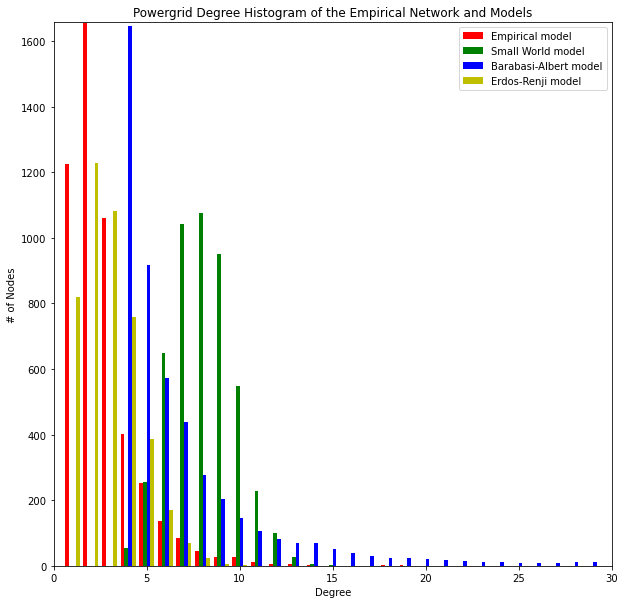

In [67]:
plot_hist(g2, g2_sw, g2_ba, g2_er, 'Powergrid')

### Distribution of Degrees

In [71]:
def plot_distribution(g, g_sw, g_ba, g_er, dataset_name):

    # Empirical Network
    degs0 = list(dict(nx.degree(g)).values())
    n0, bins0 = np.histogram(degs0, bins = list(range(min(degs0), 51, 1)), density="True")
    
    # Small World Model
    degs1 = list(dict(nx.degree(g_sw)).values())
    n1, bins1 = np.histogram(degs1, bins = list(range(min(degs1), 51, 1)), density="True")

    # Barabasi-Albert Network Model
    degs2 = list(dict(nx.degree(g_ba)).values())
    n2, bins2 = np.histogram(degs2, bins = list(range(min(degs2), 51, 1)), density="True")

   # Erdos-Renji Model
    degs3 = list(dict(nx.degree(g_er)).values())
    n3, bins3 = np.histogram(degs3, bins = list(range(min(degs3), 51, 1)), density="True")

    #to plot:
    plt.figure(figsize=(10,10)) #use once and set figure size

    plt.plot(bins0[:-1],n0,'r-', markersize=10, label="Empirical Network") 
    plt.plot(bins1[:-1],n1,'g-', markersize=10, label="Small World") 
    plt.plot(bins2[:-1],n2,'b-', markersize=10, label="Barabasi Albert") 
    plt.plot(bins3[:-1],n3,'y-', markersize=10, label="Erdos Renyi") 
    plt.legend(loc='best', shadow=True)
    plt.title(dataset_name +' Degree Distributions')
    plt.xlabel('degree, k')
    plt.ylabel('P(k)')

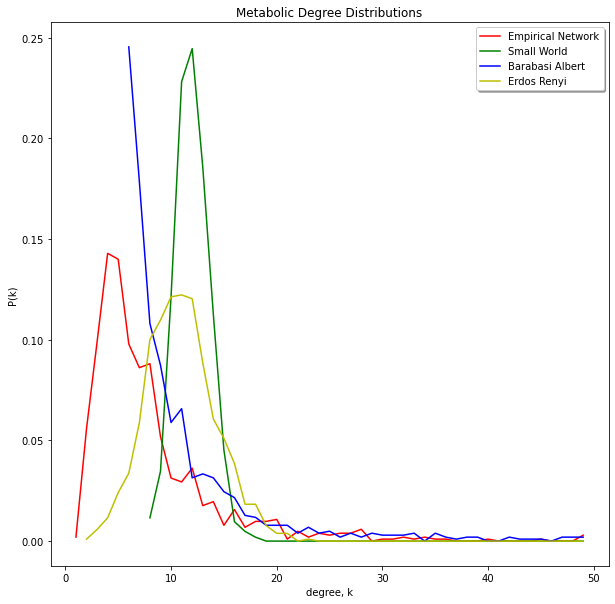

In [72]:
plot_distribution(g1, g1_sw, g1_ba, g1_er, 'Metabolic')

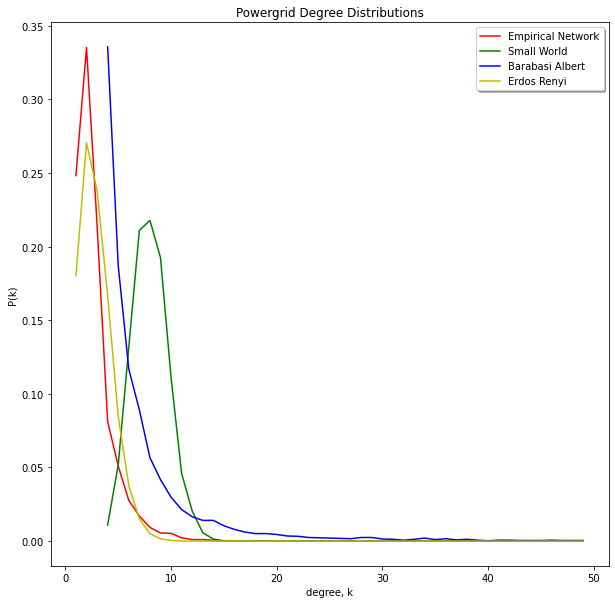

In [73]:
plot_distribution(g2, g2_sw, g2_ba, g2_er, 'Powergrid')

## Characteristics of Watts-Strogatz model

In [68]:
def sw_prop(n, k, seed):

    # Resolution (number of different values of p, the rewiring probability)
    r = 20

    # Generate a set of r logarithmically spaced values of p
    p_range = [0] + np.logspace(-4, 0, r).tolist()

    # For each p, compute the characterstic measures of the Watt-Strogatz model (n,k,p)
    clustering = []
    sp_length = []
    for p in p_range:

        # Create a Watts-Strogatz graph
        graph = nx.watts_strogatz_graph(n, k, p, seed=seed)

        # Compute the average shortest-path length L(p)
        sp_length.append(nx.average_shortest_path_length(graph))

        # Compute the clustering coefficient C(p)
        clustering.append(nx.average_clustering(graph))

    # Plot L(p)/L(0) and C(p)/C(0)
    plt.figure(1, figsize=(6, 6))
    plt.semilogx(p_range[1:], [L / sp_length[0] for L in sp_length[1:]],
                 'sb',
                 markersize=10,
                 label='L(p)/L(0) - avg. shortest path')
    plt.semilogx(p_range[1:], [C / clustering[0] for C in clustering[1:]],
                 'or',
                 markersize=10,
                 label='C(p)/C(0) - clustering coefficient')
    plt.semilogx(p_range[1:], [(1 - p)**3.0 for p in p_range[1:]],
                 '--',
                 color=[0.2, 0.2, 0.2],
                 linewidth=3,
                 markersize=12,
                 label='C(p)/C(0) - Analytical clustering')

    # Extend the plot region to see the points at both ends
    lims = plt.xlim()
    plt.xlim([lims[0] * 0.9, lims[1] * 1.1])
    lims = plt.ylim()
    plt.ylim([lims[0] * 0.95, lims[1] * 1.05])

    plt.title("Characteristics of Watts-Strogatz model with n=%d and k=%d" %
              (n, k),
              fontsize=16)
    plt.xlabel("Rewiring probabiliy (p)", fontsize=14)
    plt.ylabel("L(p)/L(0) and C(p)/C(0)", fontsize=14)
    plt.legend(loc='best')

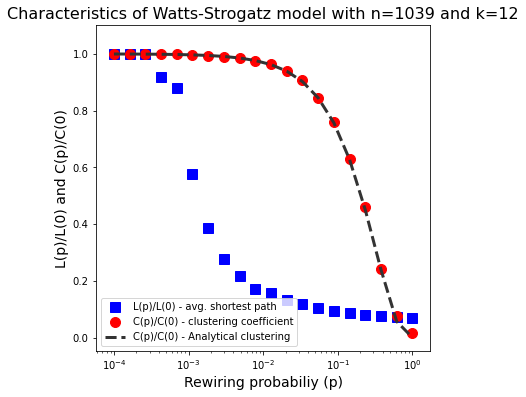

In [69]:
sw_prop(attributes_g1["#NODES"], 12, 123)

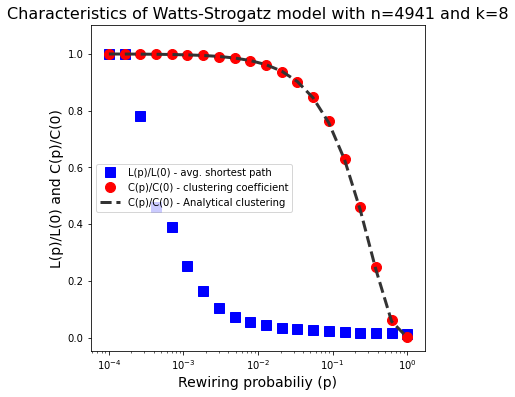

In [70]:
sw_prop(attributes_g2["#NODES"], 8, 123)